<center><h1>Условия Вольфе</center></h1>

In [249]:
import numpy as np
import numpy as np
import plotly.graph_objects as go

In [250]:
class Objectives:
    def __init__(self, function_name):
        if function_name not in {"rosenbrock", "convex"}:
            RuntimeError("no such function")
        else:
            self.__function_name = function_name
        self.__convex_a, self.__convex_b, self.__convex_c = None, None, None
        self.__ros_a, self.__ros_b, self.__ros_y = None, None, None

    def set_classic_convex_params(self, a, b, c):
        self.__convex_a = a
        self.__convex_b = b
        self.__convex_c = c

    def set_rosenbrock_params(self, a, b, y):
        self.__ros_a = a
        self.__ros_b = b
        self.__ros_y = y

    def __get_rosenbrock(self):
        f = lambda x: np.square(self.__ros_a - x) + \
                      self.__ros_b * \
                      np.square(self.__ros_y - x ** 2)

        derivative = lambda x: - 2 * (self.__ros_a - x) - \
                               4 * self.__ros_b * x * \
                               (self.__ros_y - x ** 2)
        return f, derivative

    def __get_classic_convex(self):
        f = lambda x: self.__convex_a * np.square(x) + \
                      self.__convex_b * x + self.__convex_c
        derivative = lambda x: 2 * self.__convex_a * x + self.__convex_b

        return f, derivative

    def get_function(self):
        if self.__function_name == "rosenbrock":
            return self.__get_rosenbrock()
        else:
            return self.__get_classic_convex()

In [251]:
class SteppingOverProblem:
    def __init__(self):
        self.__f, self.__grad = None, None
        self.__x_start, self.__x_end = None, None
        self.__init_coord, self.__next_step_coord = [], []
        self.__alpha = None

    def set_objective(self, objective):
        self.__f, self.__grad = objective.get_function()

    def set_range(self, x_range):
        self.__x_start, self.__x_end = x_range

    def set_init_coord(self, x_init):
        if self.__f is None:
            print(f"Сначала установите функцию")
        else:
            self.__init_coord = [x_init, self.__f(x_init)]

    def set_step_size(self, alpha):
        self.__alpha = alpha

    def __calculate_connecting_line(self):
        x0, y0 = self.__init_coord[0], self.__init_coord[1]
        x1, y1 = self.__next_step_coord[0], self.__next_step_coord[1]

        a = (y1 - y0) / (x1 - x0)
        b = y0 - a * x0

        connecting_line_x = np.linspace(x0, x1)
        connecting_line_y = a * connecting_line_x + b

        return connecting_line_x, connecting_line_y

    def calculate_next_step(self):
        x0 = self.__init_coord[0]
        x1 = x0 - self.__alpha * self.__grad(x0)
        y1 = self.__f(x1)
        self.__next_step_coord = [x1, y1]

    def __get_objective(self):
        x = np.linspace(self.__x_start, self.__x_end, 250)
        y = self.__f(x)
        return x, y

    def view_result(self):
        if self.__init_coord is not None and self.__next_step_coord is not None:
            objective_x, objective_y = self.__get_objective()
            connecting_line_x, connecting_line_y = self.__calculate_connecting_line()

            fig = go.Figure(data=[
                go.Scatter(
                    x=objective_x,
                    y=objective_y,
                    name="Целевая функция",
                    line=dict(width=2, color='royalblue')
                ),

                go.Scatter(
                    x=connecting_line_x,
                    y=connecting_line_y,
                    name="Прямая проходящая через $f(x_{0}) и f(x_{0} + ap_{0})$",
                    line=dict(width=2, color='firebrick', dash='dash')
                ),

                go.Scatter(
                    x=[self.__init_coord[0]],
                    y=[self.__init_coord[1]],
                    name="Текущий шаг",
                    mode="markers",
                    marker=dict(color="green", size=15, line=dict(color="#000000", width=2))
                ),

                go.Scatter(
                    x=[self.__next_step_coord[0]],
                    y=[self.__next_step_coord[1]],
                    name="Следущий шаг",
                    mode="markers",
                    marker=dict(color="red", size=15, line=dict(color="#000000", width=2))
                ),
            ])
            fig.update_layout(width=800, height=400, title="Иллюстрация перешагивания минимума")
            fig.show()
        else:
            print(f"Выполните действия в правильном порядке")

In [252]:
class FirstWolfesCondition:
    def __init__(self):
        self.__f, self.__grad = None, None
        self.__alpha = None
        self.__x_init = None
        self.__fig = None

    def set_objective(self, objective):
        self.__f, self.__grad = objective.get_function()

    def set_alpha(self, alpha_range):
        self.__alpha = np.linspace(alpha_range[0], alpha_range[1], 200)

    def set_init_coord(self, x_init):
        self.__x_init = x_init

    def __initialize_objective(self):
        self.__validate_initialization()
        x = self.__x_init - self.__grad(self.__x_init) * self.__alpha
        y = self.__f(x)
        objective_figure = go.Scatter(
            x=x, y=y,
            name="Целевая функция",
            line=dict(width=2, color='royalblue')
        )
        return go.Figure(data=objective_figure)

    def __validate_initialization(self):
        if self.__f is None or self.__grad is None \
                or self.__alpha is None \
                or self.__x_init is None:
            RuntimeError("Сначала установите параметры моделирования")

    def view_condition(self):
        self.__fig = self.__initialize_objective()
        x, c1_array = self.__calculate()

        steps = []
        for i in range(len(self.__fig.data) - 1):
            step = dict(method="update", args=[
                {"visible": [False] * len(self.__fig.data)},
                {"title": "Первое условие вольфе Вольфе"}
            ])
            step["args"][0]["visible"][i + 1] = True
            step["args"][0]["visible"][0] = True
            steps.append(step)
            sliders = [
                dict(active=6, steps=steps, pad={"t": 50}, 
                     currentvalue={"prefix": "Константа 1: "})
            ]
        tickvals = [np.round(x[i], 2) for i in range(len(x)) if i % 20 == 0]
        ticktext = [str(np.round(self.__alpha[i], 4)) for i in range(len(self.__alpha)) if i % 20 == 0]
        self.__fig.update_layout(sliders=sliders, width=800, height=500, 
                                 xaxis=dict(tickmode='array', tickvals=tickvals, ticktext=ticktext))
        self.__fig.update_xaxes(range=[np.min(x), np.max(x)])
        self.__fig.update_yaxes(range=[np.min(self.__f(x)) - 0.3, np.max(self.__f(x)) + 0.3])
        self.__fig.show()

    def __calculate(self):
        x = self.__x_init - self.__grad(self.__x_init) * self.__alpha
        
        beta0 = self.__f(self.__x_init)
        grad = self.__grad(self.__x_init)
        
        c1_array = np.linspace(0, 1, 40)
        for i, c1 in enumerate(c1_array):
            y = beta0 - self.__alpha * c1 * grad ** 2
            scatter = go.Scatter(
                x=x, y=y, name="Первое условие Вольфе",
                line=dict(color="firebrick", width=2),
                visible=True if i == 6 else False)
            self.__fig.add_trace(scatter)
            
        return x, c1_array

В градиентных методах численной оптимизации, известна проблема выбора шага сходимости $\alpha$. Если он достаточно большой, есть вероятность перескакивания минимума(максимума). Отсюда следует, что для эффективной оптимизации требуются ограничения.  

In [253]:
objective = Objectives("rosenbrock")
objective.set_rosenbrock_params(a=0, b=4, y=17 / 8)

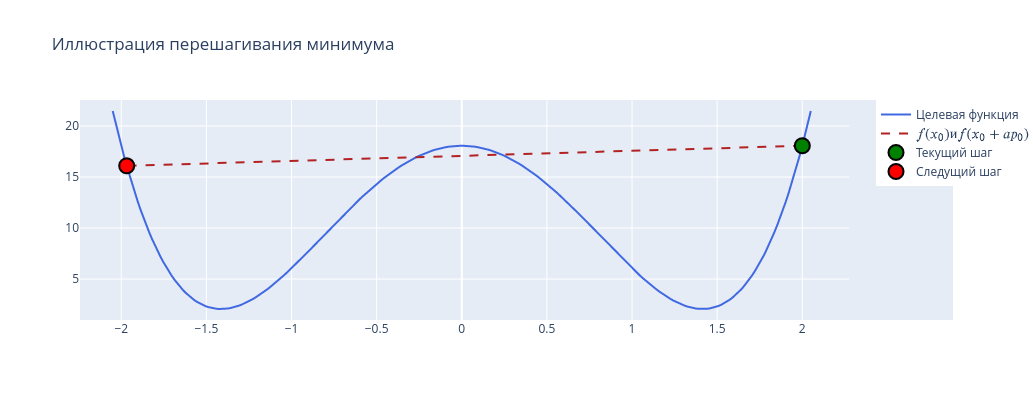

In [254]:
stepping_over = SteppingOverProblem()
stepping_over.set_objective(objective)
stepping_over.set_init_coord(2.0)
stepping_over.set_range((-2.05, 2.05))
stepping_over.set_step_size(0.062)
stepping_over.calculate_next_step()
stepping_over.view_result()

Эффективность оптимизации обеспечивается условиями Вольфе:
$$f\left(x_{k}+\alpha_{k}p_{k}\right)\leq f\left(x_{k}\right)+c_{1}\alpha_{k}\nabla f_{k}^{T}p_{k}$$
$$f\left(x_{k}+\alpha_{k}p_{k}\right)^{T}p_{k}\leq c_{2}\nabla f_{k}^{T}p_{k}$$
$$0<c_{1}<c_{2}<1$$
Где:

$x_{k}$ - Координата точки в которой находится градиентный метод в момент времени k

$\alpha_{k}$ - шаг сходимости

$p_{k}$ - Направление спуска

$c_{1}$ и $c_{2}$ вспомогательные константы

Рассмотрим первое условие. Правая часть неравенства - это разложение в ряд Тейлора целевой функции на шаге $x_{k + 1}$. 

Мы можем рассматривать целевую функцию как $\Phi\left(\alpha\right)=f\left(x_{k}+\alpha p_{k}\right)$. Можно убедиться, что это та же целевая функция. Таким образом, вместо рассмотрения шага оптимизации $\alpha$ мы будем рассматривать его вес $c_{1}$

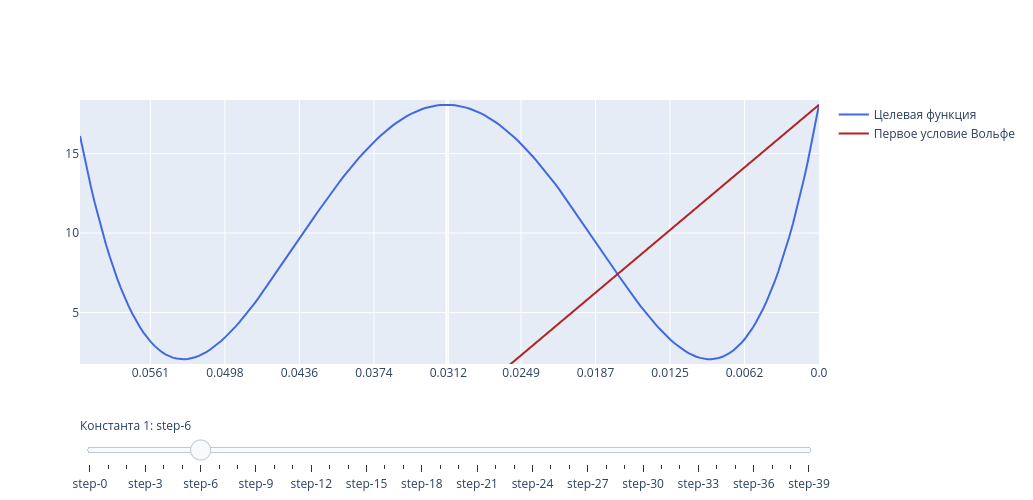

In [255]:
first_condition = FirstWolfesCondition()
first_condition.set_objective(objective)
first_condition.set_alpha((0, 0.062))
first_condition.set_init_coord(2.0)
first_condition.view_condition()

Варьируя параметр $c_{1}$ можно увидеть, что при $c_{1}=0$ (слайдер с краю слева) правая часть условия Вольфе является горизонтальной прямой. В этом случае, мы заметим, что для всех точек функции $\Phi\left(\alpha\right)$ существует определенная область значений $\alpha$, при которых функция $\Phi\left(\alpha\right)$ будет меньше чем на шаге оптимизации $x_{k}$. Однако при определенных $\alpha$ оптимизация на следующем шаге может вообще не произойти. А именно при таких $\alpha$ при которых $\Phi\left(\alpha\right)$ неизменна. Если мы установим слайдер с краю справа, мы заметим, что при $c_{1}=1$ функция остается в точке $x_{k}$. 

На мой взгляд из-за таких случаев введено второе условие сходимости, которое говорит что значение на следующем шаге должно быть меньше чем на текущем
$$f\left(x_{k}+\alpha_{k}p_{k}\right)^{T}p_{k}\leq c_{2}\nabla f_{k}^{T}p_{k}$$

Эти условия используются, например, для неточного линейного поиска шага сходимости для дальнейшей оптимизации. Рекомендации по выбору констант следующие: $c_{1}$ должен быть близок к нулю а $c_{2}$ близок к единице

Вектор дальнейшего анализа: Усиленные условия Вольфе. Неточный линейный поиск